In [1]:
import mdtraj as md
import matplotlib.pyplot as plt
import numpy as np
import torch


from writhe_tools.utils import reindex_list # convenience function
from writhe_tools.md_tools import get_residues # convenience function for getting residue names from mdtraj.Trajectory

In [2]:
traj = md.load("/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd",
               top="/home/t/writhe/actr/actr.pdb").center_coordinates()
xyz = traj.atom_slice(traj.top.select("name CA")).xyz
residues = get_residues(traj)

 #### Instantiate an instance of the writhe class with the coordinates to use in the calculation

In [3]:
from writhe_tools.writhe import Writhe
writhe = Writhe(xyz=xyz)

Compute the writhe using segment length=1 and speed test.

Here, the protein has 71 residues and the simulation has ~30,000 frames.

We'll compute writhe using parallelized cpu computation.

In [7]:
writhe.compute_writhe(length=1, speed_test=True)

2024-10-02 23:24:09,985	INFO worker.py:1636 -- Started a local Ray instance.


Time elapsed : 10.418234825134277 s


Utilize cuda enabled GPUs. Multiple GPUs will be used if available and computation is large enough to warrant their usage (i.e. faster to use them, determined internally)

Here, we just use 1 GPU

In [8]:
writhe.compute_writhe(length=1, speed_test=True, cuda=True)
# when using GPUs in jupyter, need to be careful about memory

Time elapsed : 2.6273534297943115 s


 ##### if memory issues arrise due to using GPUs, you can troubleshoot using  writhe_tools.utils.gpu_stats()
 
 ##### If issues are persistent, it's advisable to simply set cuda=False for writhe computations. The cpu based calculation is optimized and performed in parallel. It is also written slightly differently than the GPU / torch version to minimize peak memory usage.
 
 ##### if GPU memory becomes an issue after computing the writhe, writhe_tools.utils.cleanup(), may help with emptying cache and collecting garbage
 
 #### The output is muted in online upload.

from writhe_tools.utils import gpu_stats, cleanup
gpu_stats()
cleanup()

In [10]:
# check stats again after clean up
gpu_stats()

 Now we compute without the speed test and store the results in the class.
 
 The results of the calculation are also returned as a dictionary.
 
 The class will store the results of a calculation by default but this behavior can be controlled by the store_results parameter. The stored results can then be easily saved, as shown below.

In [7]:
writhe.compute_writhe(length=1, speed_test=False, cuda=True, store_results=True)
writhe.save(dir="./example_results", dscr="actr") #class will give the saved result an appropriate name with the description

 #### we made a directory called example results. Here's the pickled python dictionary file 

In [8]:
# find saved results on computer
!ls example_results | grep writhe_data_dict_length_1

actr_writhe_data_dict_length_1.pkl


#### Now, let's compute the writhe for a series of different segment lengths and save our results


In [9]:
from writhe_tools.utils import Timer
with Timer():
    for length in range(2, 6):
        writhe.compute_writhe(length, cuda=True)
        writhe.save(dir="./example_results", dscr="actr") # class save file name that includes length

Time elapsed : 5.206992149353027 s


#### Let's check that the results have saved successfully

In [10]:
# find saved results on computer
!ls example_results | grep writhe_data_dict

actr_writhe_data_dict_length_1.pkl
actr_writhe_data_dict_length_2.pkl
actr_writhe_data_dict_length_3.pkl
actr_writhe_data_dict_length_4.pkl
actr_writhe_data_dict_length_5.pkl


 #### Check the results of the calculation by loading them back into memory, one at a time. 
 
 #### Notice that the class architecture is designed to make computation and retreival of the data convienient, so always choose to compute save and then load rather than keeping multiple instances of the writhe class in memory at the same time. 

 #### All plots in the next cell are made with writhe_tools.writhe.Writhe class methods

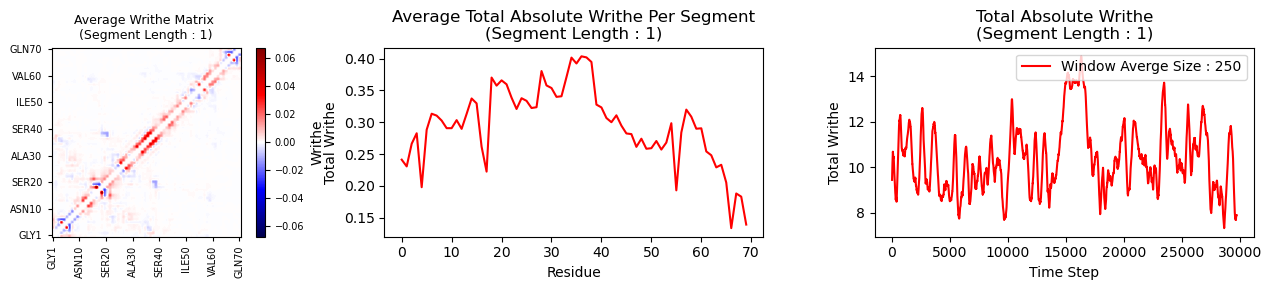

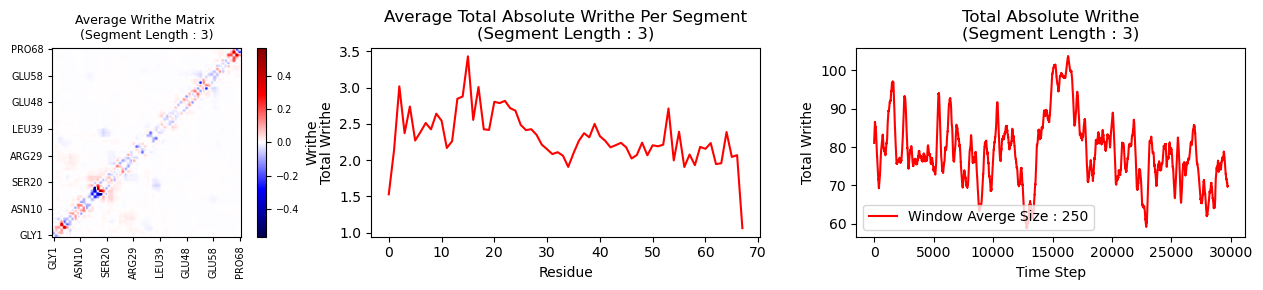

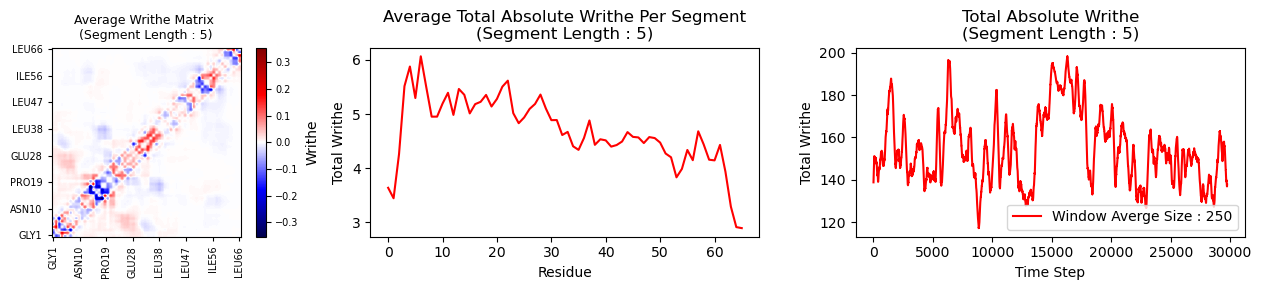

In [32]:
for length in [1, 3, 5]:    
    # restore the results of the calculation
    writhe = Writhe.load(f"example_results/actr_writhe_data_dict_length_{length}.pkl")
    # note that restoring the class will not restore the coordinates used in the calulation just the results.
    fig, axes = plt.subplots(1, 3, figsize=(14, 3))
    ax=axes.flat
    writhe.plot_writhe_matrix(ax=ax[0], xticks=residues, yticks=residues, label_stride=8)
    writhe.plot_writhe_per_segment(ax=ax[1])
    writhe.plot_writhe_total(ax=ax[2], window=250)
    fig.tight_layout()

 ### Note that ensemble avermaging the writhe matrix often leads to sparse results for dynamic proteins as isotropic changes in crossings can result in a mean near zero. This doesn't necessarily mean that there aren't crossings or that the writhe features are mostly zero!
 ####  Let's Perform tCCA, cluster, look at average writhe matrices for representative structures from 8 clusters.
 #### We'll also compute residue distances and perform tCCA on those, so we can compare the results.

In [145]:
from writhe_tools.tcca import tCCA
from writhe_tools.stats import Kmeans
from writhe_tools.utils import sort_indices_list #sort indices wrt various order parameters

# compute tCCA on unique writhe features for lengths 1, 3, 5 # note that this is a huge calculation!!
# if the protein has sequence length < 45, consider using only lengths 1, 3 or just length 1

writhe_tcca = tCCA(
    np.concatenate([Writhe.load(f"example_results/actr_writhe_data_dict_length_{i}.pkl").writhe_features
                    for i in [1, 3]], 1), 
                lag=31, dim=10)

writhe_proj = writhe_tcca.fit_transform()
writhe_dtraj, writhe_frames = Kmeans(writhe_proj, n_clusters=12, n_dim=3)
obs = abs(writhe.writhe_features).sum(-1)
writhe_frames = sort_indices_list(writhe_frames, obs)
indices = np.array([obs[i].mean() for i in writhe_frames]).argsort()[::-1]
writhe_frames = [writhe_frames[i] for i in indices]

### Compute distances, perform tCCA

In [150]:
from writhe_tools.md_tools import ResidueDistances

# # WARNING ; this class computes distances in its init statement (no modifications can be made to the computation regardless)
distances = ResidueDistances(index_0=np.arange(71), traj=traj, chain_id_0="ACTR")


# optionally save results
distances.save("./example_results/distances_data_dict.pkl")

# then the distances class can be restored for analysis / plotting
distances = ResidueDistances.load("./example_results/distances_data_dict.pkl")

# perform tCCA, project distances
distances_tcca = tCCA(data=distances.distances, lag=31, dim=10)
distances_proj = distances_tcca.fit_transform()

#distances_dtraj = Kmeans(distances_proj, n_clusters=40, n_dim=3)[0]


 ##### saved result file for the distances

In [16]:
!ls example_results | grep distances

distances_data_dict.pkl


 ### Compare the writhe, contacts and distances for each cluster

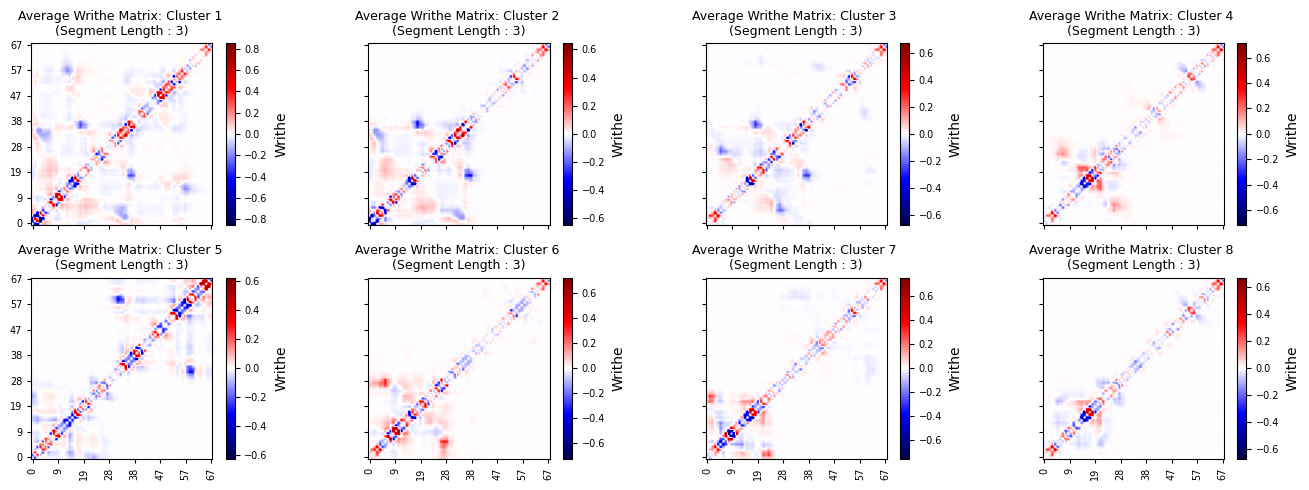

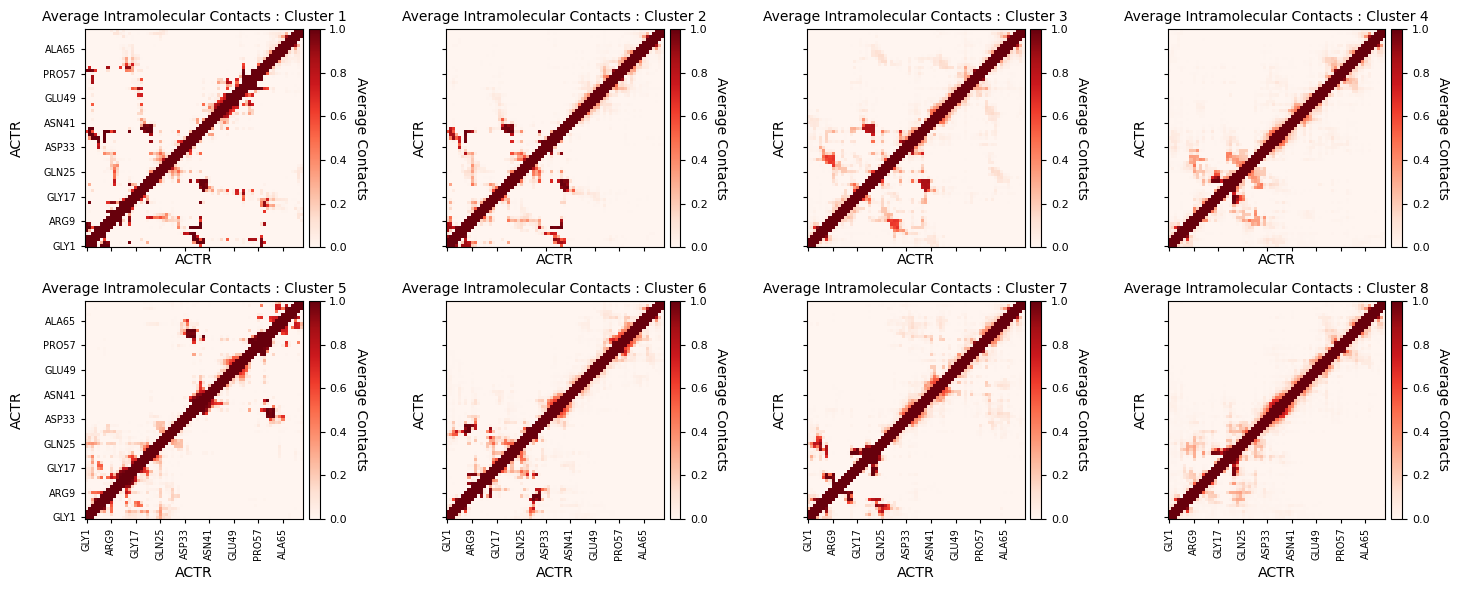

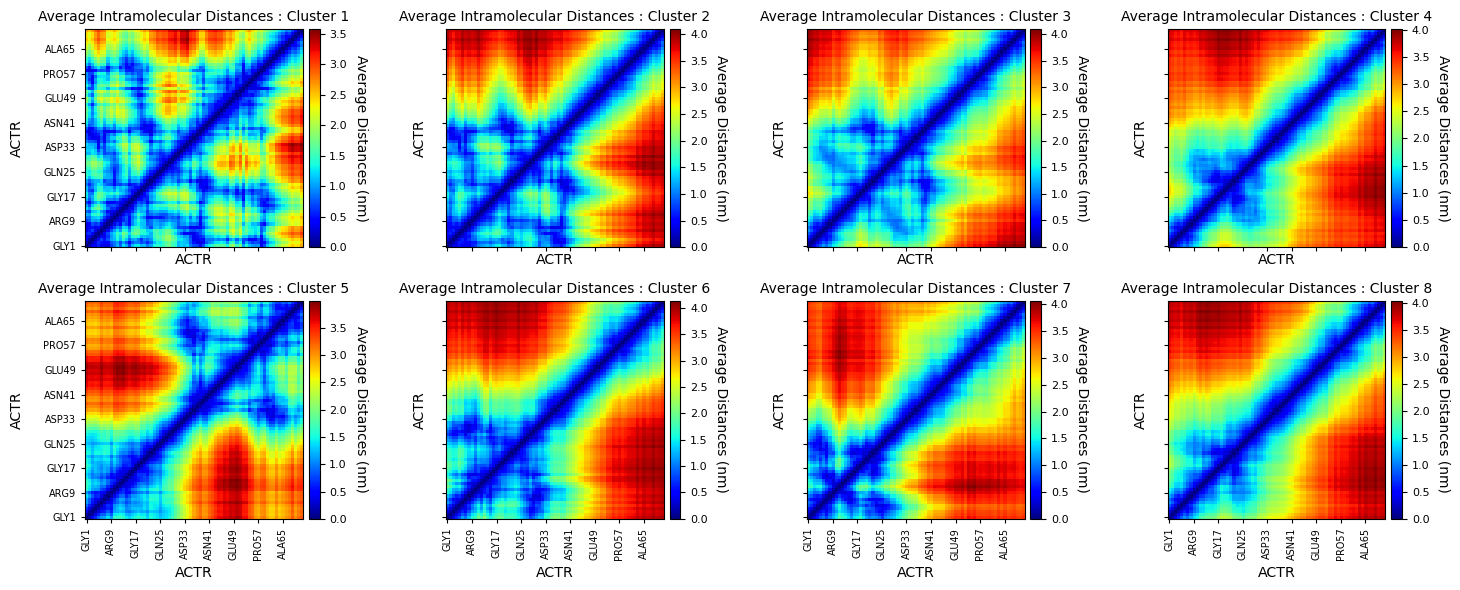

In [90]:
# we'll visualize segment length 3
#writhe = Writhe.load("example_results/actr_writhe_data_dict_length_3.pkl")

idx = np.stack([indices_stat(writhe_frames, i)[-1] for i in
            [np.sum(writhe.writhe_features * (writhe.writhe_features > 0), 1),
            -np.sum(writhe.writhe_features * (writhe.writhe_features < 0), 1)]
           ], 1)

states = np.unique(idx.flatten())[:8]
# plot writhe for clusters
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(14, 5))
for index, (i, ax) in enumerate(zip(reindex_list(writhe_frames, states), axes.flat)):
    writhe.plot_writhe_matrix(index=i, ax=ax, label_stride=8, dscr=f"Cluster {index+1}")
fig.tight_layout()


# plot contacts for same clusters
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15, 6))
for index, (i, ax) in enumerate(zip(writhe_frames[:5000], axes.flat)):
    distances.plot(index=i, ax=ax, label_stride=8, dscr=f"Cluster {index+1}", contacts=True,
                  cmap="Reds")
fig.tight_layout()


# plot distances for same clusters
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15, 6))
for index, (i, ax) in enumerate(zip(writhe_frames[:10], axes.flat)):
    distances.plot(index=i, ax=ax, label_stride=8, dscr=f"Cluster {index+1}")
fig.tight_layout()



 # Let's compare the distances and writhe tCCA projections
    

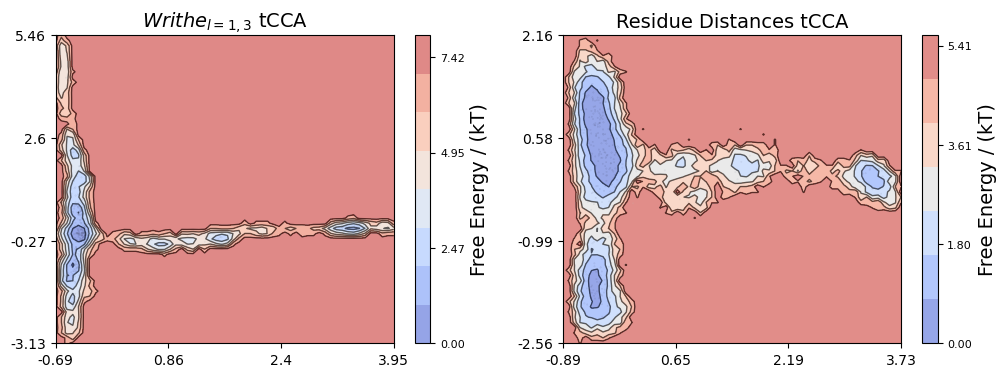

In [91]:
from writhe_tools.plots import fes2d


fig, axes = plt.subplots(1, 2, figsize= (12, 4))
ax = axes.flat


fes2d(writhe_proj[:, :2],
      bins=60,
      contour_lines=True,
      n_contours=8,
      scatter=True,
      mask=False,
      cmap="coolwarm",
      alpha_contours=.6,
      ax=ax[0],
      title=r"$Writhe_{l=1,3}$ tCCA",
      )

fes2d(
      distances_proj[:, :2],
      bins=60,
      contour_lines=True,
      n_contours=8,
      scatter=True,
      mask=False,
      cmap="coolwarm",
      alpha_contours=.6,
      ax=ax[1],
      title="Residue Distances tCCA",
      )

 ### We see that the writhe projection leads to a free energy surface with many more basins, allowing us to isolate more structurally distinct, metastable states. The axis labels also tell us that the writhe reactions coordinates have greater kinetic variance. 
 
 ### Let's compare those kinetic variances summed over the first ten components (VAMP2 score)


In [106]:
print(f"Writhe tCCA kinetic variance (VAMP2 score) : {np.sum(writhe_tcca.svals**2):.1f}")
print(f"Distances tCCA kinetic variance (VAMP2 score) : {np.sum(distances_tcca.svals**2):.1f}")

Writhe tCCA kinetic variance (VAMP2 score) : 9.9
Distances tCCA kinetic variance (VAMP2 score) : 9.3


 #### for this plot, we're going to use the tCCA projection from the writhe computed using length 1 in order to reproduce a figure from the paper. You can SKIP THE CELL BELOW if you're following along with different data.

In [72]:
### skip if you want to use tCCA from lengths 1 and 3

# running tCCA on concatenated writhe features for length 1 only
# np.save("./example_results/writhe_tcca_proj_length_1_lag_31.npy",
#        tCCA(writhe.load("example_results/actr_writhe_data_dict_length_1.pkl").writhe_features,
#            lag=31,
#            dim=10).fit_transform()
#         )

# we'll use the data from writhe (l=1) to match the paper figure
# proj is already defined in previous cell, so this can be skipped

writhe_proj_ = np.load("./example_results/writhe_tcca_proj_length_1_lag_31.npy")

 ### let's examine the densities of the latent spaces on the strip  that runs along the tCCA 2
 
 #### if you're following along with your own data, SKIP THIS CELL AND RUN THE NEXT

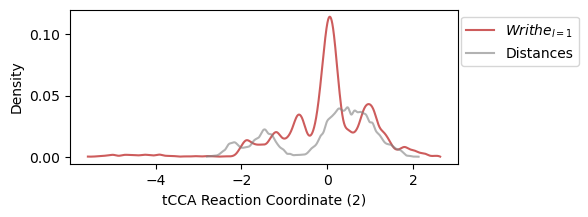

In [73]:
from writhe_tools.stats import smooth_hist

plt.figure(figsize=(5,2))
idx = writhe_proj[:, 0] < -.1

plt.plot(*smooth_hist(writhe_proj_[:, 1][idx], bins=70, samples=10000),
         color='indianred',
         label=r"$Writhe_{l=1}$")

plt.plot(*smooth_hist(distances_proj[:, 1][idx], bins=70, samples=10000),
         color="gray",
         alpha=.6,
         label="Distances")

plt.xlabel("tCCA Reaction Coordinate (2)")
plt.ylabel("Density")
plt.legend(bbox_to_anchor=[1.33,1])

In [ ]:
# plot all of one component

dim = 1 # choose the dimension to plot

plt.figure(figsize=(5,2))

plt.plot(*smooth_hist(writhe_proj_[:, dim], bins=70, samples=10000),
         color='indianred',
         label=r"$Writhe_{l=1}$")

plt.plot(*smooth_hist(distances_proj[:, dim], bins=70, samples=10000),
         color="gray",
         alpha=.6,
         label="Distances")

plt.xlabel("tCCA Reaction Coordinate (dim)")
plt.ylabel("Density")
plt.legend(bbox_to_anchor=[1.33,1])

 # Estimate msms from clusters
 
 #### the clustering code is provided again here.
 
 #### When estimating MSMs, we often want to use a larger number of clusters and then coarse-grain down to a smaller number of states for visualization. 
 
 #### Here, you'll probably want to experiment with larger numbers of clusters and the lag time used to compute the tCCA projections.
 
 #### These hyparameters will have a large effect on the model


In [198]:
# if you want to estimate new MSMs from the clusters of writhe and distances tCCA
from writhe_tools.msm_tools import MarkovModel # based on deeptime package - here only for convenience
writhe_dtraj, distances_dtraj = (Kmeans(i,
                                        n_clusters=40,
                                        n_dim=4,
                                        n_init=100,
                                        max_iter=1000,
                                        #init='random',
                                       )[0] for i in (writhe_proj, distances_proj))

writhe_msm = MarkovModel(dtraj=writhe_dtraj, dt=0.2).estimate_msm(lag=5, steps=7)
distances_msm = MarkovModel(dtraj=distances_dtraj, dt=0.2).estimate_msm(lag=5, steps=7)


In [200]:
# # here, we load previous result to exactly match the paper 
writhe_msm = MarkovModel.load("/home/t/writhe/actr/msm/writhe_msm_long").estimate_msm(5, 7) # use previous result for writhe
distances_msm = MarkovModel.load("/home/t/writhe/actr/msm/distance_msm_long").estimate_msm(5, 7)

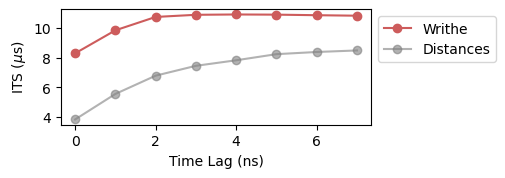

In [201]:
plt.figure(figsize=(4, 1.5))
plt.plot(writhe_msm.msm["its_est"][0]*1e-3, #convert to microseconds
         color='indianred',
         label="Writhe",
         marker="o")

plt.plot(distances_msm.msm["its_est"][0]*1e-3, #convert to microseconds
         color="gray",
         alpha=.6,
         label="Distances",
         marker="o")

plt.xlabel("Time Lag (ns)")
plt.ylabel(r"ITS ($\mu$s)")
plt.legend(bbox_to_anchor=[1,1])